In [2]:
from requests import get

from bs4 import BeautifulSoup
import pandas as pd
import time
import status
from sklearn.cluster import KMeans as km
import numpy as np
import matplotlib.pyplot as plt
import re, string, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from nltk.corpus import stopwords
stop_words = set(stopwords.words("italian"))
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from translate import Translator
from langdetect import detect
import math 

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stemmer = SnowballStemmer('italian')

plt.style.use('ggplot')

####
In this task we are going to make clustering on realestate data using two different approaches, and then compare the resut of each approach.
The source of our data is *www.immobiliare.it* webiste, which provides realestate advertising service in Italy.
In this web data extraction task we will scrap the search page on the mentioned website to read the information we are interested in and store it locally on a dataframe object.
Since we are dealing with a website, we are using __request__ library to initiate __GET__ request to the search page URL:
https://www.immobiliare.it/vendita-case/roma/
The expected result of the search page will be an HTML file (which is in fromat of XML tree), to deal with this response we are keeping it in  __Beautifulsoup__ object, so that we are able to access its tags and attributes to get the information we are interested in.

The search shows 25 listings per page, so we used the *pag* parameter added to the *url* to navigate the pages beyond the first one.
During the scraping we ignored any listing with any missing information.
We are going to retrieve 15k listings from the website to build our first dataset (__df_info__), we are specifically interested in  information about Price, Locali, Superficie, bagni, and Piano, in addition to retrieving the URL for each listing in order to be used to scrap the detail page of the listing in building the second dataset.

As we are sending too many automated HTML requests to the same website form same IP, we are concerned about being blocked by the website, so we are using __sleep()__ from __time__ library to delay the execution of the requests by fixed delay time.

Since we are expecting long time of execution, we are anticipating any kind of disconnectivity from our side, or from server side, so to avoid losing the data we retrieved before the disconnection we made our scraping function to be visible, by using a global variable as a counter *pg* which start from 1 and increase by navigating the result pages.

# Web Scraping

In [2]:
# url: is the URL of the main search page we are going to scrap.
url = 'https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='
# page counter
pg = 1
# time period to delay the requests
tm = 2
# the first dataset to store listings' data
df_info = pd.DataFrame(columns=['url','price','locali','superficie','bagni','piano'])


In [4]:
# The scraping function: takes two parameters: the dataset, and the max listings we want to scrap (15k in our case) 
def scrapInfo(df_info, maxEntries):
    # the gloabl variables we used to make the function continuable in case of interruption.
    global pg, tm
    
    # Start from where we stopped last time of execution until we reach the max requested number.
    i = len(df_info.index)
    while i <= maxEntries:
        
        # delay execution for a fixed period
        time.sleep(tm)
        
        # create a response object as a result of Get request to the target URL (passing page counter to the URL)
        response = get(url+str(pg))
        
        # create beautifulsoup object to parse the text of the response 
        html_soup = BeautifulSoup(response.text, 'html.parser')
        
        # seeking the Div tags with class value =listing-item_body--content where our target data are located.
        item_containers = html_soup.find_all('div', class_ = 'listing-item_body--content')
        
        # loop over the divs (since each div represents a listing)
        for item in item_containers:
            
            # initiated a temporary list for each loop to store the information we need.
            listing = []
            
            # first get the URL of the listing, to be used for scraping the description of the listing.
            listing.append(item.a['href'])
            
            # The rest of the information are located within a list, so we loop over its items.
            for d in item.ul.find_all('li', class_ = 'lif__item'):
                
                try:
            
                    # the price item has a different class(lif__pricing), so we can easily get the information from this item
                    # by seeking the text value of the item.
                    if 'lif__pricing' in d['class']:
                        listing.append(d.text.strip().split(' ')[1])
                        next
                    
                    # The rest of item have same class name, but different text values, 
                    # and the useful information is located inside a span tag, so we are checking the text for each list item
                    # to determine what is the information this item holds.
                    else:
                        if d.find('div', class_='lif__text').text == 'locali':
                            listing.append(d.span.text)
                        if d.find('div', class_='lif__text').text == 'superficie':
                            listing.append(d.span.text)
                        if d.find('div', class_='lif__text').text == 'bagni':
                            listing.append(d.span.text)
                        if d.find('div', class_='lif__text').text == 'piano':
                            listing.append(d.abbr.text.strip())
                except:
                    next
            # In case any of the requested information is missing for any reason, just ignore this listing,
            # otherwise store the temporary list into the main dataset.
            if len(listing) == 6:
                df_info.loc[len(df_info.index)+1] = listing
                i +=1
        # by the end of this loop we scraped all listing on this page, so we navigate to the next page by increasing page counter.
        pg+=1
    return(df_info)

In [ ]:
# calling the scraping function for 15k entries
df_info = scrapInfo(df_info, 15000)



In this step we need to retrieve detail information about the ads on the website, targetting the very same items collected in our first dataset, that's why we stored the url for each item in the previous step.

We do the same scraping technique but this time we target the URL page for each item in our previous dataset.
We iterate over the rows of the first dataset and get the URL value, and pass it to the __get__ function to get the HTML result with the detail information about the listing.

As we did before, in order to make the function continuable in case of any interruption or disconnection, we used a global variable pointing to the last item we retrieved, and once we restart the scraping we strat from where we arrived the previous time.

And during the scraping, we also take care of any failure in retrieving some items infromation (due to any kind of reasons), in this case we ignore the item, and we save the id of this item in one list *failedToRetrieve* in order to delete the same items from the first dataset.


In [6]:
# creating dataframe object to store the second dataset
df_desc = pd.DataFrame(columns=['id','title','description'])

# global var pointing to the last retrieved item
pg_desc = 0
tm = 0.3

In [7]:
# list of the item failed to retrieve, so we can delete them from the first dataset as well
failedToRetrieve = []

# scraping function, takes two parameters: the second dataset, and the number of item to scrap.
def scrapDetails(df_desc, n):
    
    global pg_desc, tm, df_info
    
    # for each item in the first dataset do the scraping
    for index, row in df_info[pg_desc:pg_desc+n].iterrows():
        listing = []
        listing.append(index)
        
        # get the url for the lsiting item from the first dataset
        url_ = row['url']
        response = get(url_)
        if response.status_code == 200:
            try:
                html_zuppa = BeautifulSoup(response.text, 'html.parser')
                # our information is located under h1 element (the title), and a div element containing the description
                listing.append(html_zuppa.find('h1', class_='raleway title-detail').text.strip())
                listing.append(html_zuppa.find('div', class_='description-text').div.text.strip())
                
                # save the information in the second dataset
                df_desc.loc[len(df_desc.index)+1] = listing
                pg_desc += 1
                time.sleep(tm)
            except:
                # in case of any failure, add the index value to the failed list.
                failedToRetrieve.append(index)
                # in case of failure fill the row with None values
                df_desc.loc[len(df_desc.index)+1] = [index,None,None]
                
        else:
            failedToRetrieve.append(index)
            df_desc.loc[len(df_desc.index)+1] = [index,None,None]

    return(df_desc)

In [ ]:
# retrieving on phases..
tm = 0.2

#df_desc = scrapDetails(df_desc, 1000)

df_desc = scrapDetails(df_desc, 492)


In [ ]:
# of course we must store these files
df_desc.to_csv('df_desc_15k.csv')
df_info.to_csv('df_info_15k.csv')

In [101]:
# read from file
df_info = pd.read_csv('df_info_15k.csv')
df_desc = pd.read_csv('df_desc_15k.csv')

Now we clean both datasets as we explained before:

In [113]:
df_info = df_info.drop(df_info.index[failedToRetrieve])
df_desc = df_desc.drop(df_desc.index[failedToRetrieve])

In [114]:
df_info.describe()

,Unnamed: 0,superficie
count,14705.000000,14705.000000
mean,7461.890377,105.748120
std,4326.255029,56.113492
min,1.000000,1.000000
25%,3713.000000,70.000000
50%,7439.000000,92.000000
75%,11197.000000,128.000000
max,15004.000000,900.000000


Remaining datasets are in size of 14705 out of 15004 retrieved.


Now we change data types in first dataset to setup it for the clustering procedures.
...

In [116]:
df_info.locali.unique()

array(['2\xa0', '3\xa0', '5+\xa0', '5\xa0', '4\xa0', '1\xa0'],
      dtype=object)

In [117]:
mapLocali = {'2\xa0':2, '3\xa0':3, '5+\xa0':6, '5\xa0':5, '4\xa0':4, '1\xa0':1}
df_info['locali'] = df_info['locali'].replace(mapLocali)

In [119]:
df_info.locali.unique()

array([2, 3, 6, 5, 4, 1])

In [120]:
df_info.piano.unique()

array(['1', '4', 'R', 'T', '2', 'A', '3', '5', 'S', '7', '9', '6', '8',
       '11+', '10'], dtype=object)

In [122]:
mapPiano = {'T':0, 'A':12, 'S':-1, '11+':11, 'R':0.5}
df_info['piano'] = df_info['piano'].replace(mapPiano)
df_info.piano.unique()


array(['1', '4', 0.5, 0, '2', 12, '3', '5', -1, '7', '9', '6', '8', 11,
       '10'], dtype=object)

In [124]:
df_info.bagni.unique()

array(['1\xa0', '3\xa0', '2\xa0', '3+\xa0'], dtype=object)

In [126]:
mapBagni = {'1\xa0':1, '2\xa0':2, '3\xa0':3, '3+\xa0':3.5}
df_info['bagni'] = df_info['bagni'].replace(mapBagni)
df_info.bagni.unique()

array([1. , 3. , 2. , 3.5])

In [127]:
df_info['price'] = [x.replace(".","").replace("€","") for x in df_info['price']]

In [131]:
df_info['price'] = pd.to_numeric(df_info['price'])
df_info['locali'] = pd.to_numeric(df_info['locali'])
df_info['superficie'] = pd.to_numeric(df_info['superficie'])
df_info['bagni'] = pd.to_numeric(df_info['bagni'])
df_info['piano'] = pd.to_numeric(df_info['piano'])

In [72]:
# clean the datasets from "strange" values
removing_index = []
l = []
l.append(df_info.loc[df_info.price > 10**8].index)
l.append(df_info.loc[df_info.price < 10**3].index)
l.append(df_info.loc[df_info.superficie > 800].index)
l.append(df_info.loc[df_info.superficie < 5].index)
for i in l:
    for j in i:
        removing_index.append(j)

In [73]:
removing_index

[508, 3723, 8910, 4221, 843, 4604, 4913, 5269, 8776, 11118, 12272]

In [86]:
#let's remove this index from the dataframes:
df_info = df_info.drop(df_info.index[removing_index])
df_desc = df_desc.drop(df_desc.index[removing_index])

In [87]:
df_info = df_info.reset_index()
df_desc = df_desc.reset_index()

In [90]:
df_info

,index,url,price,locali,superficie,bagni,piano
0,0,https://www.immobiliare.it/53131931-Vendita-Bi...,225000,2,50.0,1.0,1.0
1,1,https://www.immobiliare.it/70479086-Vendita-Tr...,189000,3,79.0,1.0,1.0
2,2,https://www.immobiliare.it/68601391-Vendita-At...,1650000,6,220.0,3.0,4.0
3,3,https://www.immobiliare.it/67242549-Vendita-Ap...,1050000,6,290.0,2.0,0.5
4,4,https://www.immobiliare.it/65564714-Vendita-Ap...,1250000,5,185.0,3.0,0.0
5,5,https://www.immobiliare.it/70147844-Vendita-Tr...,349000,3,100.0,1.0,2.0
6,6,https://www.immobiliare.it/69489650-Vendita-Qu...,1350000,4,200.0,2.0,2.0
7,7,https://www.immobiliare.it/65915711-Vendita-Ap...,1700000,6,460.0,3.5,0.0
8,8,https://www.immobiliare.it/66712707-Vendita-Qu...,690000,4,127.0,2.0,1.0
9,9,https://www.immobiliare.it/69206492-Vendita-Tr...,165000,3,60.0,1.0,12.0


In [91]:
df_info = df_info.drop(columns = "index")
df_desc = df_desc.drop(columns = "index")

In [95]:
# these are the clean datasets that we will use to do the clusters, so we must store them
df_info.to_csv('dataset_info_15k.csv')
df_desc.to_csv('dataset_desc_15k.csv')

In [29]:
# read from file
df_info = pd.read_csv('dataset_info_15k.csv')
df_desc = pd.read_csv('dataset_desc_15k.csv')

In [100]:
df_info = df_info.drop('Unnamed: 0', axis=1)
df_desc = df_desc.drop('Unnamed: 0', axis=1)

In [101]:
df_info.head()

,url,price,locali,superficie,bagni,piano
0,https://www.immobiliare.it/53131931-Vendita-Bi...,225000,2,50.0,1.0,1.0
1,https://www.immobiliare.it/70479086-Vendita-Tr...,189000,3,79.0,1.0,1.0
2,https://www.immobiliare.it/68601391-Vendita-At...,1650000,6,220.0,3.0,4.0
3,https://www.immobiliare.it/67242549-Vendita-Ap...,1050000,6,290.0,2.0,0.5
4,https://www.immobiliare.it/65564714-Vendita-Ap...,1250000,5,185.0,3.0,0.0


In [102]:
df_desc.head()

,title,descrition
0,"Bilocale viale Italo Calvino, Roma",PAPILLO EUR in elegante complesso residenziale...
1,"Trilocale via Ignazio Scimonelli 130, Roma",Rif: 18110 - ROMANINA (ad. Cinecittà Est) - Vi...
2,"Attico / Mansarda via Nicolò Piccolomini, Roma","A pochi passi da Villa Pamphili, e precisament..."
3,"Appartamento via Luigi Ungarelli, Roma","Nel cuore del quartiere Nomentano e, esattamen..."
4,"Appartamento via Delle Isole, Roma",Elegante appartamento ristrutturato in Via del...


# Clustering

In [30]:
df_kmeans = df_info[["price","locali","superficie","bagni","piano"]]
d = {} #lista degli inertia
k_max = 10
K = range(1, 1+k_max)
for i in K:
    # creates the clusters for k = i
    res = km(i).fit(df_kmeans)
    d[i] = res.inertia_

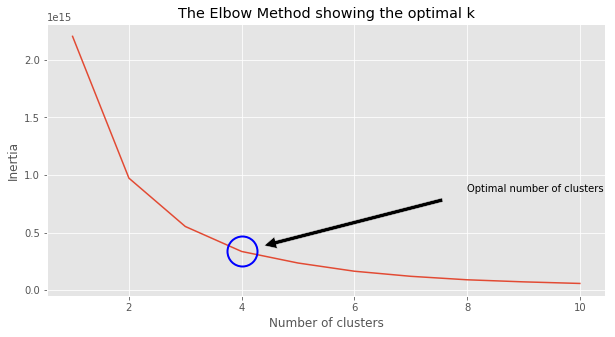

In [31]:
x = list(d.keys())
y = list(d.values())
fig = plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x[3], y[3], 'o', ms=30, mec='b', mfc='none', mew=2)
plt.annotate('Optimal number of clusters', 
             xy=(4,336650333257310.28), xytext=(8,855386193505651.3),
             arrowprops = dict(facecolor='black', shrink=0.1))
plt.title('The Elbow Method showing the optimal k')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [37]:
# creates the clusters for k = 4
res = km(4).fit(df_kmeans)
# creates the dic of the clusters
diclust_info = {i : set() for i in res.labels_}
for i in range(len(res.labels_)):
    diclust_info[res.labels_[i]].add(i)

In [38]:
diclust_info

{0: {0,
  1,
  5,
  9,
  20,
  22,
  23,
  25,
  27,
  28,
  32,
  34,
  39,
  41,
  45,
  47,
  48,
  49,
  54,
  55,
  57,
  59,
  60,
  63,
  66,
  67,
  68,
  69,
  73,
  74,
  77,
  78,
  81,
  90,
  91,
  92,
  94,
  95,
  101,
  104,
  105,
  107,
  108,
  111,
  112,
  113,
  115,
  116,
  117,
  119,
  120,
  121,
  125,
  126,
  129,
  133,
  134,
  135,
  137,
  138,
  140,
  142,
  143,
  145,
  146,
  147,
  150,
  151,
  153,
  155,
  156,
  157,
  159,
  160,
  164,
  170,
  175,
  178,
  183,
  184,
  186,
  187,
  189,
  191,
  192,
  196,
  200,
  207,
  215,
  216,
  218,
  220,
  221,
  222,
  225,
  226,
  227,
  229,
  238,
  241,
  244,
  247,
  248,
  252,
  255,
  257,
  260,
  261,
  262,
  263,
  264,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  285,
  287,
  290,
  302,
  305,
  311,
  312,
  319,
  323,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  340,
  342,
  343,
  3

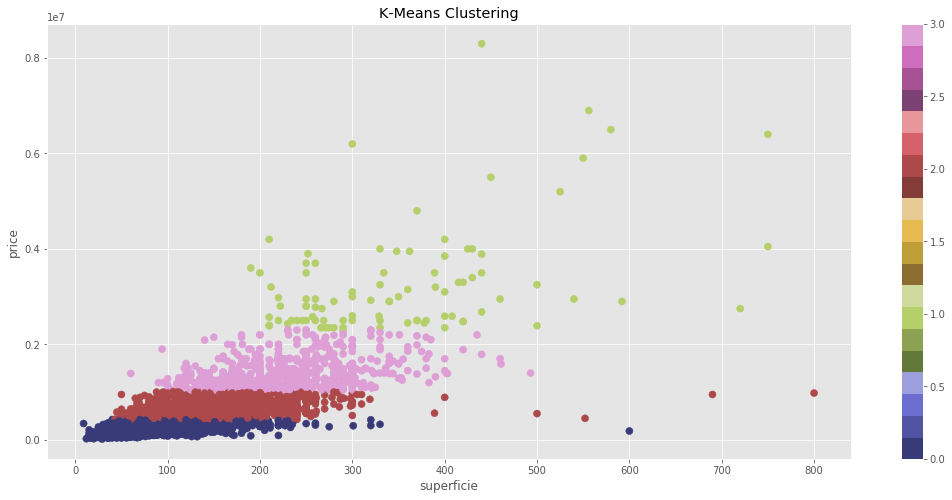

In [107]:
# Let's plot the clusters obtained using k means, focusing on Price and Superficie, since they are with the widest ranges
# and most impact
fig = plt.figure(figsize=(18,8))
#fig, ax = plt.subplots(figsize=(15,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(df_kmeans['superficie'],df_kmeans['price'],
                     c=res.labels_,s=50, cmap="tab20b")
ax.set_title('K-Means Clustering')
ax.set_xlabel('superficie')
ax.set_ylabel('price')
plt.colorbar(scatter)
plt.show()

We can see that there's some correlation between Price and Superficie

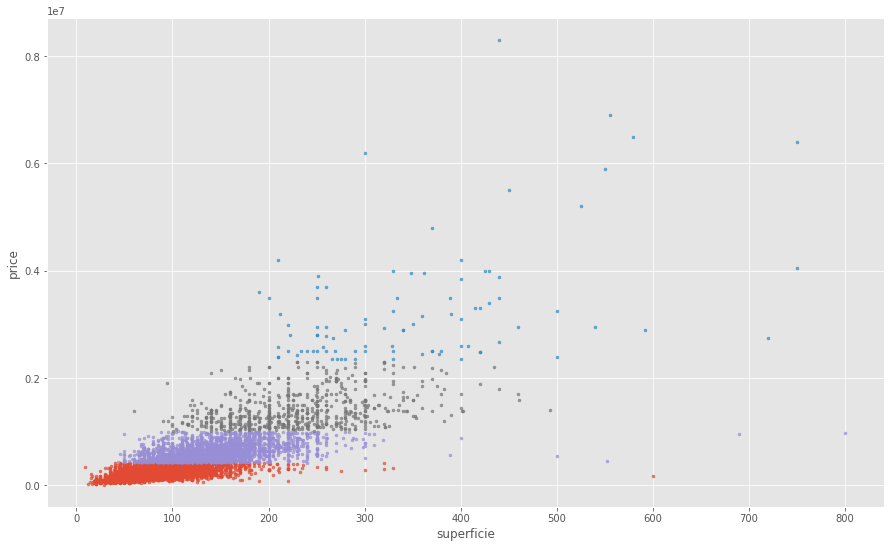

In [108]:
slice = df_kmeans[["price","locali","superficie","bagni","piano"]]
centroids = res.cluster_centers_ #clust_labels = res.predict(df_kmeans)
c = res.predict(slice)
slice["clusters"] = c
fig = plt.figure(figsize=[15,9])
#plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='red')

for clust in range(0,4):
    plt.scatter(slice[slice.clusters == clust]["superficie"],
            slice[slice.clusters == clust]["price"], 
             marker='.', alpha=0.7, cmap="tab20b")
plt.xlabel("superficie")
plt.ylabel("price")
plt.show()

In [109]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\gabbr\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

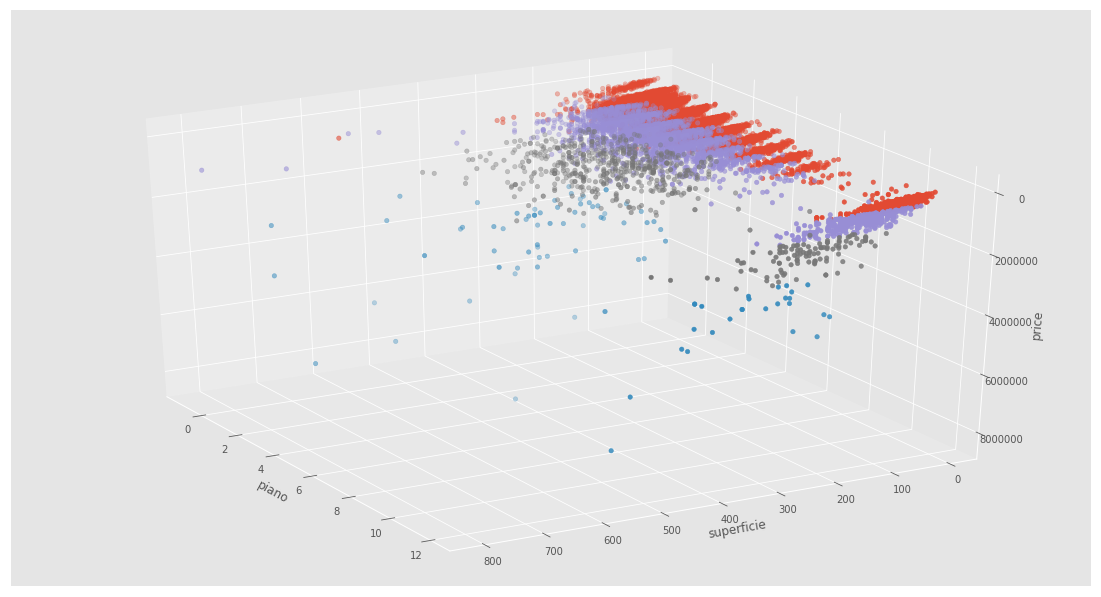

In [110]:
# we repeat the same thing but in 3D with piano, superficie and price

plt.clf()
fig = plt.figure(figsize=(15, 8))
ax = Axes3D(fig, elev=-150, azim=210)
for k in range(0,4):
    ax.scatter3D(slice[slice.clusters==k]["piano"], 
                 slice[slice.clusters==k]["superficie"], 
                 slice[slice.clusters==k]["price"])
ax.set_xlabel("piano")
ax.set_ylabel("superficie")
ax.set_zlabel("price")
#plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
#plt.gca().invert_zaxis()

fig.show()
fig.savefig("plot3d.png", dpi=300)

### to do the clustering for the second dataset, we must create a TFIDF matrix from the second dataset

first we define the functions to clean the data

In [111]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    
    new_words = []
    words=re.sub(r'\n',' ',words)
    for word in words.split():
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with null"""
    new_words = []
    for word in words:
        if word.isdigit():
            pass
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('italian'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [112]:
def cleaning_data(a):
    '''
    this function takes a string in input, cleans it, and returns a list with all the 'clean' words in the initial string
    '''
    a=a.replace('\\n',' ')
    a=a.replace('\\',' ')
    a=remove_non_ascii(a)
    a=to_lowercase(a)
    a=remove_punctuation(a)
    a=replace_numbers(a)
    a=remove_stopwords(a)
    a=stem_words(a)
    a=lemmatize_verbs(a)
    return a

In [123]:
df = pd.read_csv("dataset_desc_15k.csv")
df.rename(columns={'descrition': 'description'}, inplace=True)

In [124]:
df_cleaned = dict()
ind = 0
for i in range(len(df)):
    a = df.title[ind] + df.description[ind]
    if isinstance(a, str): 
        a = cleaning_data(a)
        df_cleaned[ind] = a
        ind += 1

In [125]:
# Storing the df_cleaned file 
np.save('df_cleaned.npy', df_cleaned)

In [126]:
# Loading the df_cleaned file
df_cleaned = np.load('df_cleaned.npy').item()

In [127]:
set_parole = set()
for i in df_cleaned:
    for word in df_cleaned[i]:
        set_parole.add(word)

In [128]:
# Storing the set_parole file 
np.save('set_parole.npy', set_parole)

In [129]:
# Loading the set_parole file
set_parole = np.load('set_parole.npy').item()

In [130]:
print(len(df),len(df_cleaned),len(set_parole))

14694 14694 30395


In [131]:
dict_parole = {}
i = 0
for word in set_parole:
    dict_parole[i] = word
    i += 1

In [132]:
N = len(df_cleaned) #number of documents
W = len(dict_parole) #number of words

In [133]:
matrix = np.zeros(len(dict_parole)*len(df_cleaned))
matrix = matrix.reshape(len(df_cleaned), len(dict_parole))

In [134]:
for i in range(len(df_cleaned)):
    l = len(df_cleaned[i])
    for j in range(len(dict_parole)):
        if dict_parole[j] in df_cleaned[i]:
            matrix[i,j] = (df_cleaned[i].count(dict_parole[j]))/l 
# this algo creates a matrix with the i,j element is the TF of the word j in the document i

In [135]:
# Storing the matrix
np.save('matrix.npy', matrix)

In [136]:
#creates the matrix TFIDF
for i in range(len(df_cleaned)):
    for j in range(len(dict_parole)):
        if matrix[i,j] > 0:
            matrix[i,j] = matrix[i,j]*(np.log(N/(np.count_nonzero(matrix[:,j])))) 

In [137]:
# Storing the inv_ind file 
np.save('TFIDF.npy', matrix)

In [4]:
# Loading the TFIDF_matrix
matrix = np.load('TFIDF.npy')

In [5]:
# fraction of non zero on zero values %
print("so the", round((100 * (1 - np.count_nonzero(matrix) / np.count_nonzero(matrix == 0))),2) , 
      "% of the elements in the matrix are 0")

so the 99.72 % of the elements in the matrix are 0


since the number of 0s is too high:

In [6]:
# let's remove from the matrix the column with just one element
unique_words = []
for j in range(matrix.shape[1]):
    if np.count_nonzero(matrix[:,j]) == 1:
        unique_words.append(j)

In [7]:
matrix = np.delete(matrix, unique_words, 1)

In [8]:
# Storing the TFIDF Matrix cleaned in a file 
np.save('TFIDF_cleaned.npy', matrix)

In [9]:
# fraction of non zero on zero values %
print("with the cleaned TFIDF matrix, the", round((100 * (1 - np.count_nonzero(matrix) / np.count_nonzero(matrix == 0))),2) , 
      "% of the elements in the matrix are 0")

with the cleaned TFIDF matrix, the 99.49 % of the elements in the matrix are 0


#### let's do the elbow method for this matrix

In [19]:
# Loading the TFIDF_matrix
matrix = np.load('TFIDF_cleaned.npy')

due to the high amount of time needed to compute the kmeans, let's limit the maximum number of iteration at 50

In [20]:
d = {} #lista degli inertia
k_max = 8
K = range(1, 1+k_max)
for i in K:
    # creates the clusters for k = i
    res = km(i, max_iter=50).fit(matrix)
    d[i] = res.inertia_

In [21]:
d

{1: 2412.3853901807406,
 2: 2402.1436408364875,
 3: 2391.2262704847803,
 4: 2391.3229730585645,
 5: 2388.3897683208497,
 6: 2377.851940124746,
 7: 2386.4534475848814,
 8: 2369.78560030803}

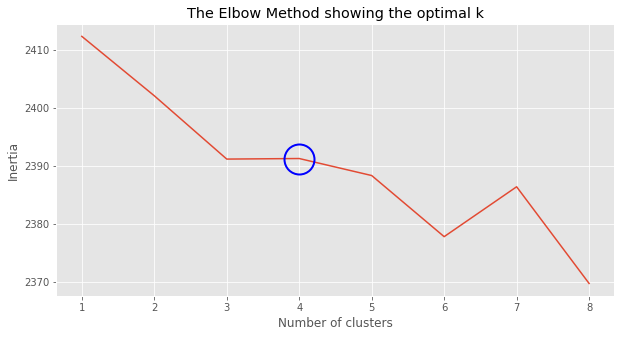

In [22]:
x = list(d.keys())
y = list(d.values())
fig = plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x[3], y[3], 'o', ms=30, mec='b', mfc='none', mew=2)
plt.title('The Elbow Method showing the optimal k')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

since the elbow method it's not significant, we take $k=4$ that's the same value for the previous clustering

In [23]:
# creates the clusters for k = 4
res = km(4).fit(matrix)
# creates the dic of the clusters
diclust_desc = {i : set() for i in res.labels_}
for i in range(len(res.labels_)):
    diclust_desc[res.labels_[i]].add(i)

In [24]:
diclust_desc

{0: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  17,
  18,
  21,
  24,
  25,
  29,
  30,
  31,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  43,
  44,
  47,
  48,
  49,
  51,
  52,
  53,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  67,
  70,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  82,
  83,
  84,
  85,
  87,
  88,
  89,
  91,
  93,
  94,
  96,
  98,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  112,
  115,
  116,
  118,
  119,
  120,
  123,
  124,
  127,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  139,
  140,
  141,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  151,
  152,
  153,
  154,
  155,
  156,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  168,
  169,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  190,
  192,
  193,
  194,
  195,
  197,
  198,
  199,
  200,
  201,
  202,

# Jaccard Similarity

In [25]:
def jaccard(A, B):
    N = len(A.intersection(B))
    D = len(A.union(B))
    return (N/D)

In [39]:
lista_jacc = []
for i in diclust_info:
    for j in diclust_desc:
        jac = round(jaccard(diclust_info[i],diclust_desc[j]), 3)
        print("La Jaccard Similarity tra i cluster", i, j, "è:", jac)
        lista_jacc.append((jac, i, j))

La Jaccard Similarity tra i cluster 0 0 è: 0.614
La Jaccard Similarity tra i cluster 0 3 è: 0.014
La Jaccard Similarity tra i cluster 0 2 è: 0.155
La Jaccard Similarity tra i cluster 0 1 è: 0.004
La Jaccard Similarity tra i cluster 1 0 è: 0.046
La Jaccard Similarity tra i cluster 1 3 è: 0.011
La Jaccard Similarity tra i cluster 1 2 è: 0.034
La Jaccard Similarity tra i cluster 1 1 è: 0.005
La Jaccard Similarity tra i cluster 2 0 è: 0.226
La Jaccard Similarity tra i cluster 2 3 è: 0.017
La Jaccard Similarity tra i cluster 2 2 è: 0.092
La Jaccard Similarity tra i cluster 2 1 è: 0.004
La Jaccard Similarity tra i cluster 3 0 è: 0.006
La Jaccard Similarity tra i cluster 3 3 è: 0.01
La Jaccard Similarity tra i cluster 3 2 è: 0.002
La Jaccard Similarity tra i cluster 3 1 è: 0.0


In [40]:
jaccs = sorted(lista_jacc, reverse=True)
print("The highest 3 jaccard similarity are: (jaccard, clusterA, clusterB) \n")
for i in range(3):
    print(jaccs[i])  

The highest 3 jaccard similarity are: (jaccard, clusterA, clusterB) 

(0.614, 0, 0)
(0.226, 2, 0)
(0.155, 0, 2)


then we represent the words in each couple of these $3$ clusters in a **wordcloud**

In [42]:
# Loading the df_cleaned file
df_cleaned = np.load('df_cleaned.npy').item()

In [43]:
def wordcloudPlot(i, j):
    intersezione = diclust_info[i].intersection(diclust_desc[j])
    text = [' '.join(i for i in df_cleaned[j]) for j in intersezione]
    text = ' '.join(i for i in text)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

The wordclouds for the highest 3 jaccard similarity are: 

(0.614, 0, 0)


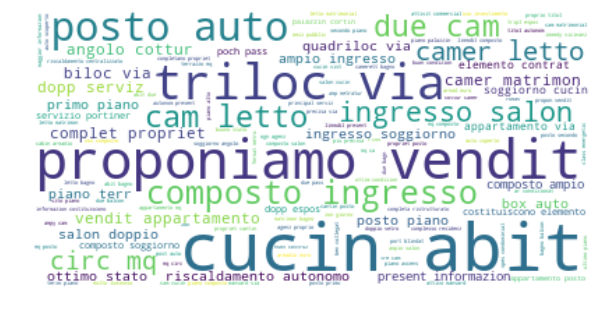

(0.226, 2, 0)


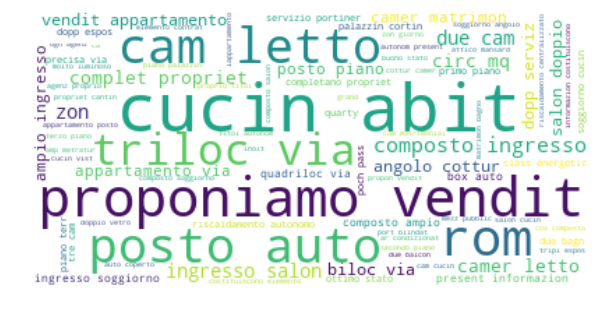

(0.155, 0, 2)


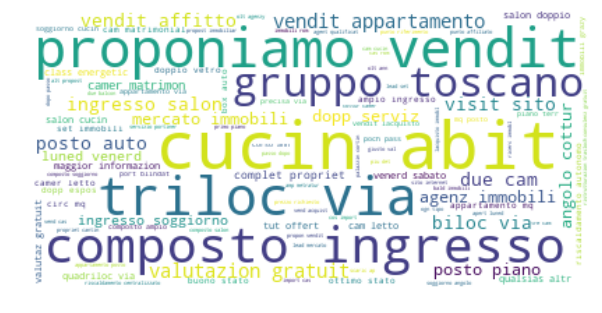

In [44]:
jaccs = sorted(lista_jacc, reverse=True)
print("The wordclouds for the highest 3 jaccard similarity are: \n")
for i in range(3):
    print(jaccs[i])
    wordcloudPlot(jaccs[i][1], jaccs[i][2])

so we can say that there is high Jaccard Similarity only between the 0 - 0 clusters

# Task 2:
In this task we should create a hash function. This function should create unique keys for different passwords in the given set of passwords. This passwords are stored in the .txt file. The volume of this file is 2.2 GB so it is impossible to open it. So the only way to see what is inside is to read this file line by line. Because of huge size this file we are not able to store the passwords for each key. So we will store only the keys and the value which indicates the number of time it appears in our dataset. We also cannot process data at the same time. The solution was to divide our dataset to 11 parts by 10 million elements. In order to find total number of collisions we should compare all dictionaries pairwise. Because of difficulties of storing all the data in RAM (Memory Error) and storing all the data in hard drive (too slow) we should be sure that our function does not create collisions for different passwords. So we should create an ideal hash function. The most simple ideal hash function is the following:

In [2]:
count=0
for line in open("passwords2.txt"): count += 1
print(count)

110000000


In [7]:
#This hash fuction take a string replace each symbol by its ascii code and then retrun an integer.
def hashfunc(line):
    line="".join(map(str,map(ord,list(line))))
    return int(line)
#This function save dictionaries for the first part of task 2.
import json
def savedict1(i, hashtable):
    with open('hashsort_'+str(i)+'.json', 'w') as fp:
        json.dump(hashtable, fp)
        
#This function save dictionaries for the second part of task 2.
def savedict2(i, hashtable):
    with open('hash_'+str(i)+'.json', 'w') as fp:
        json.dump(hashtable, fp)
#This function upload dictionaries for the first part of task 2.
def loaddict1(i):
    with open('hashsort_'+str(i)+'.json', 'r', encoding='latin-1') as fh:
        return json.load(fh)
#This function save dictionaries for the second part of task 2.
def loaddict2(i):
    with open('hash_'+str(i)+'.json', 'r', encoding='latin-1') as fh:
        return json.load(fh)

#Hashing procedure where we sort each password in order to eliminate the effect of character order.
def hsh1(i,j):
    hashtable={}
    for count, line in enumerate(open("passwords2.txt")):
        if count>j:break
        if count>i:
            line = ''.join(sorted(line)).replace('\n','') # line is sorted to eliminate the effect of character order.
            pswd = hashfunc(line)
            if pswd in hashtable:
                hashtable[pswd]+= 1 # we add 1 for each apperance of the key
            else: 
                hashtable[pswd] = 1 # we set 1 for firat appearance of the key
    return hashtable

#Hashing procedure without sorting. This alghoritm is for the second part of task 2 where order of characters matters.
def hsh2(i,j):
    hashtable={}
    for count, line in enumerate(open("passwords2.txt")):
        if count>j:break
        if count>i:
            line = ''.join(line).replace('\n','') #line is transferred to the function as it is
            pswd = hashfunc(line)
            if pswd in hashtable:
                hashtable[pswd]+= 1 # we add 1 for each apperance of the key
            else: 
                hashtable[pswd] = 1 #we set 1 for firat appearance of the key
    return hashtable

#This function is for finding collisions. We use to different functions 
#because each of them work with different set of dictionaries     
#We compare all dictionaries pairwise and sum number of appearance of similar keys.
def collis1(m,n, collisions):
    for i in range(m,n):
        for j in range(i,n):
            if i!=j:
                a=loaddict1(i) # Download dict i
                b=loaddict1(j) # Download dict i
                keys = set(a.keys()) & set(b.keys()) # Finding an intersection of keys set
                if len(keys)>0: # If the intersection is not empty we add all keys to the dictionary for collisions
                    for l in keys:
                        if l in collisions:
                            collisions[l]+=b[l]
                        else:
                            collisions[l]=(a[l]+b[l])
                    b[l]=0
                    with open('hashsort_'+str(j)+'.json', 'w') as fp:
                            json.dump(b, fp)
                del a
                del b
            print(i,j)

def collis2(m,n, collisions):
    for i in range(m,n):
        for j in range(i,n):
            if i!=j:
                a=loaddict2(i)
                b=loaddict2(j)
                keys = set(a.keys()) & set(b.keys())
                if len(keys)>0:
                    for l in keys:
                        if l in collisions:
                            collisions[l]+=b[l]
                        else:
                            collisions[l]=(a[l]+b[l])
                    b[l]=0
                    with open('hash_'+str(j)+'.json', 'w') as fp:
                            json.dump(b, fp)
                del a
                del b
            print(i,j)

In [4]:
import timeit

for i in range(0,11):
    start= timeit.default_timer()
    savedict1(i, hsh1(i*10000000,int(str(i)+'9999999')))
    stop = timeit.default_timer()
    print(stop-start)
    
# Time which had been spent to process each 10 million lines in "passwords2.txt"   
# 243.496362756
# 260.271747126
# 263.569554765
# 263.2084668279999
# 257.424944763
# 256.46789563100015
# 262.38184332699984
# 271.60103359100003
# 280.80782302000034
# 294.91677568399973
# 278.18861836899987

243.496362756
260.271747126
263.569554765
263.2084668279999
257.424944763
256.46789563100015
262.38184332699984
271.60103359100003
280.80782302000034
294.91677568399973
278.18861836899987


In [90]:
import timeit

for i in range(0,11):
    start= timeit.default_timer()
    savedict2(i, hsh2(i*10000000,int(str(i)+'9999999')))
    stop = timeit.default_timer()
    print(stop-start)
    
# Time which had been spent to process each 10 million lines in "passwords2.txt"   
# 265.70729268051946
# 283.3725139366652
# 288.7854252443358
# 291.88867031924747
# 293.40318001718697
# 298.36319830860884
# 306.5899071003005
# 315.33167866613803
# 318.5940585930075
# 298.0282006149937
# 310.53915180915646

265.70729268051946
283.3725139366652
288.7854252443358
291.88867031924747
293.40318001718697
298.36319830860884
306.5899071003005
315.33167866613803
318.5940585930075
298.0282006149937
310.53915180915646


Now we are going to get two dictionaries consisting of collisions.

In [9]:
col1={}
collis1(0,11, col1)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 5
5 6
5 7
5 8
5 9
5 10
6 6
6 7
6 8
6 9
6 10
7 7
7 8
7 9
7 10
8 8
8 9
8 10
9 9
9 10
10 10


In [10]:
col1

{'384142576162667478828390100102104105106108115121': 2,
 '35444849515358606567707284878897111115117118': 2,
 '343841495054596465757685879098101105108114122': 2,
 '3335384041576277808182848589102104107108121122': 2,
 '354144495563676870717380818790100105108109119': 2,
 '363941485556657177788598102105107115118120121122': 2,
 '343641445262677376788182899098106111115121122': 2,
 '334249515759616573788487100105108113116118120122': 2,
 '3338434551586063656669747778808187103113121': 2,
 '3744455162667173747580828687909899105109122': 2,
 '3638424345495061676971738186889799106107117': 2,
 '33354046485455616465717998100104105110111117121': 2,
 '3443515859606164757879818488100103104106108115': 2,
 '3840474857596162646670737679105108116117119122': 2,
 '33394345485054616566687678808386103104107114': 2,
 '3842434548516167687279849899103104107108118119': 2,
 '45464749535564676876808798105106109112117120121': 2,
 '3334373841444752576876777890102103105106108109': 2,
 '5260636465707678818790103108109110

Our algorithm discovers all the duplicates for the case when we do not consider the order of characters in a password. Hash function which we used does not creat any additional collisions.
Let`s check if this algorithm creates collisions in case __"ABAA != AAAB"__.

In [12]:
print(len(col1))
with open('col1.json', 'w') as fp:
        json.dump(col1, fp)

In [1]:
import json
with open('col1.json', 'r', encoding='latin-1') as fh:
        col = json.load(fh)
print(len(col))

9999999


In [13]:
col2={}
collis2(0,11, col2)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 5
5 6
5 7
5 8
5 9
5 10
6 6
6 7
6 8
6 9
6 10
7 7
7 8
7 9
7 10
8 8
8 9
8 10
9 9
9 10
10 10


In [14]:
print(len(col2))
with open('col2.json', 'w') as fp:
        json.dump(col2, fp)

4999999


In [15]:
col2

{'394512110044805557371229887103117616966833548': 2,
 '121643770454872765612265116335910740346388118': 2,
 '110119693612058568782651177384816610357713733': 2,
 '10634494311466567868797010255456512186855875': 2,
 '8339117899012142508510377647599813310410065107': 2,
 '38107345310066984687122375810174106881181038672': 2,
 '44108838562666590116107706957120751188110537112': 2,
 '105116656946769710760120473937627774121836756': 2,
 '10997110828511212049704341581136089487984116118': 2,
 '106119481211037510061495777835387120107527011444': 2,
 '995986105581161128341718546387581100114494364': 2,
 '117112121616072765510512070376499108511183810771': 2,
 '11811270533384454077101386564105741065711682122': 2,
 '799897875337107814766897555807149113735988': 2,
 '8910469113388554102864276901081203943533611050': 2,
 '86119888010799421017387397651526569633384103': 2,
 '79406072827387341201156851121103468189706786': 2,
 '8010386108815376991165739404110510277971154767': 2,
 '994560474451108777537695589986734

As we can see for the case __"ABAA != AAAB"__ there are near 5 million collisions. In respect that our function does not create any collisions for passwords with different set of characters and different order of characters (because ascii table is one to one correspondence) it means that in "passwords2.txt" there are 5 million equal passwords. False Positive in our case is zero.